In [3]:
import pandas as pd
pd.set_option('display.max_columns', 40)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

## Import data

In [4]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
# both = pd.concat([train[test.columns], test])

print(f'Length of train set: {len(train)}')
print(f'Length of test set: {len(test)}')

Length of train set: 26570
Length of test set: 20775


In [8]:
train.product_code.unique()

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

In [20]:
train.head(3)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0


#### Usefull for later

In [ ]:
int_cols = [f for f in train.columns if train[f].dtype == int and f != 'failure']
float_cols = [f for f in train.columns if train[f].dtype == float]
string_cols = [f for f in train.columns if train[f].dtype == object]

## Target column

<AxesSubplot:>

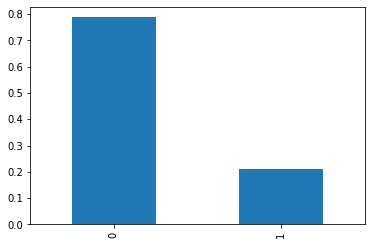

In [30]:
train['failure'].value_counts(normalize=True).plot(kind='bar')

We are dealing with an imbalanced dataset, perhaps oversampling/undersampling techniques can be used

## Float columns

Missing values

In [39]:
pd.concat([train[float_cols].isna().mean().rename('missing values in train'),
           test[float_cols].isna().mean().rename('missing values in test')],
           axis=1).round(3)

,missing values in train,missing values in test
loading,0.009,0.011
measurement_3,0.014,0.016
measurement_4,0.020,0.020
measurement_5,0.025,0.024
measurement_6,0.030,0.030
measurement_7,0.035,0.035
measurement_8,0.039,0.041
measurement_9,0.046,0.044
measurement_10,0.049,0.051
measurement_11,0.055,0.055


Distributions

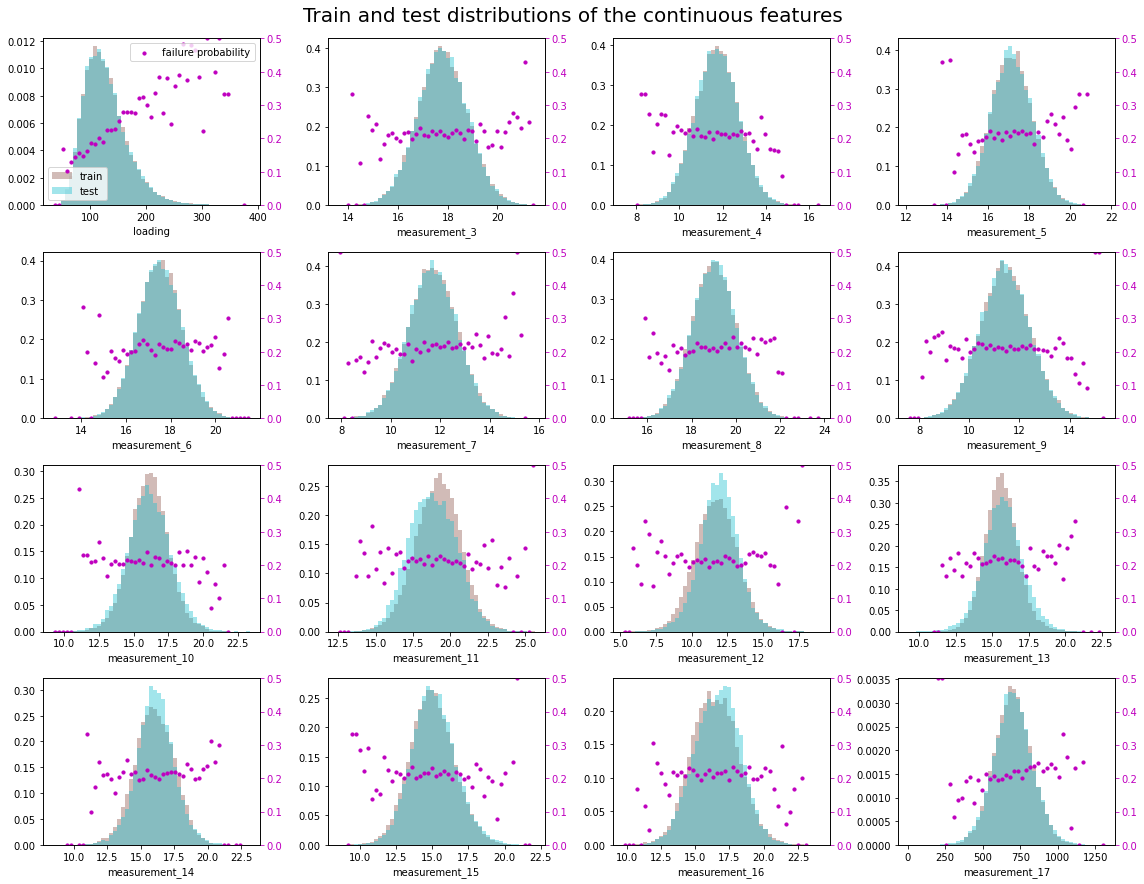

In [63]:
_, axs = plt.subplots(4, 4, figsize=(16,12))
for f, ax in zip(float_cols, axs.ravel()):
    mi = min(train[f].min(), test[f].min())
    ma = max(train[f].max(), test[f].max())
    bins = np.linspace(mi, ma, 50)
    ax.hist(train[f], bins=bins, alpha=0.4, density=True, label='train', color='tab:brown')
    ax.hist(test[f], bins=bins, alpha=0.4, density=True, label='test', color='tab:cyan')
    ax.set_xlabel(f)
    if ax == axs[0, 0]: ax.legend(loc='lower left')
        
    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures, _ = np.histogram(train[f][train.failure == 1], bins=bins)
    with warnings.catch_warnings(): # ignore divide by zero for empty bins
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        ax2.scatter((bins[1:] + bins[:-1]) / 2, failures / total,
                    color='m', s=10, label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the continuous features', fontsize=20, y=1.02)
plt.show()

Not very clear trends. Missing values carry information, following https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/342319 we can create the two columns:

In [ ]:
# X['m_3_missing'] = X.measurement_3.isna()
# X['m_5_missing'] = X.measurement_5.isna()

## Integer columns

Missing values

In [65]:
pd.concat([train[int_cols].isna().mean().rename('missing values in train'),
           test[int_cols].isna().mean().rename('missing values in test')],
           axis=1).round(2)

,missing values in train,missing values in test
attribute_2,0.0,0.0
attribute_3,0.0,0.0
measurement_0,0.0,0.0
measurement_1,0.0,0.0
measurement_2,0.0,0.0


Distributions

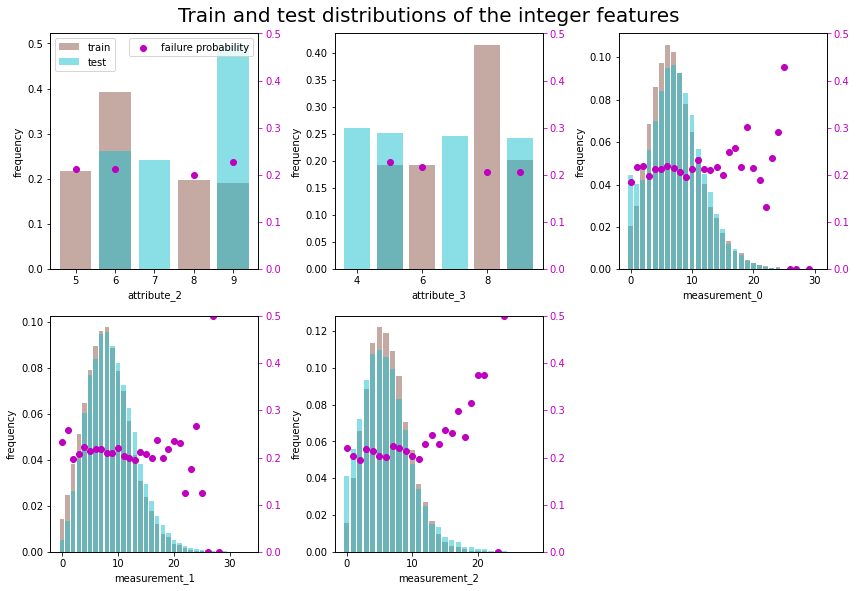

In [66]:
_, axs = plt.subplots(2, 3, figsize=(12, 8))
for f, ax in zip(int_cols, axs.ravel()):
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    ax.bar(temp1.index, temp1['size'] / len(train), alpha=0.5, label='train', color='tab:brown')
    temp2 = test[f].value_counts()
    ax.bar(temp2.index, temp2 / len(test), alpha=0.5, label='test', color='tab:cyan')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')

    ax2 = ax.twinx()
    ax2.scatter(temp1.index, temp1['mean'],
                color='m', label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')

axs[0, 0].legend()
axs[1, 2].axis('off')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the integer features', fontsize=20, y=1.02)
plt.show()
del temp1, temp2

- attribute_2 and attribute_3 can be both categorical and continous -> try both
- if treating them as categorical make sure dict_vectorizer can deal with new values in test set

## String columns

Missing values

In [67]:
pd.concat([train[string_cols].isna().mean().rename('missing values in train'),
           test[string_cols].isna().mean().rename('missing values in test')],
            axis=1).round(2)

,missing values in train,missing values in test
product_code,0.0,0.0
attribute_0,0.0,0.0
attribute_1,0.0,0.0


Distribution

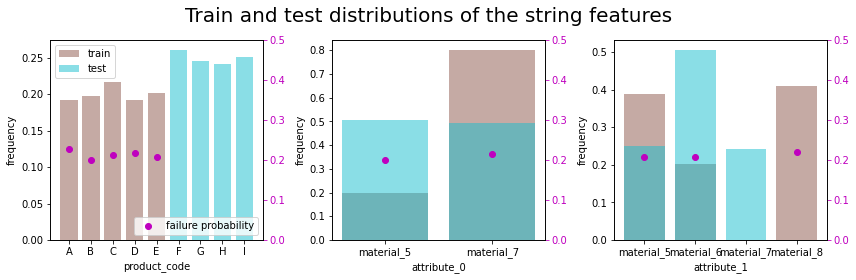

In [68]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
for f, ax in zip(string_cols, axs.ravel()):
    temp1 = train[f].value_counts(dropna=False, normalize=True)
    temp2 = test[f].value_counts(dropna=False, normalize=True)
    values = sorted(set(temp1.index).union(temp2.index))
    temp1 = temp1.reindex(values)
    temp2 = temp2.reindex(values)
    ax.bar(range(len(values)), temp1, alpha=0.5, label='train', color='tab:brown')
    ax.bar(range(len(values)), temp2, alpha=0.5, label='test', color='tab:cyan')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')
    ax.set_xticks(range(len(values)), values)
    
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    temp1 = temp1.reindex(values)
    ax2 = ax.twinx()
    ax2.scatter(range(len(values)), temp1['mean'],
                color='m', label='failure probability')
    ax2.tick_params(axis='y', colors='m')
    ax2.set_ylim(0, 0.5)
    if ax == axs[0]: ax2.legend(loc='lower right')

axs[0].legend()
plt.suptitle('Train and test distributions of the string features', fontsize=20, y=0.96)
plt.tight_layout(w_pad=1)
plt.show()
del temp1, temp2  

- product_code is disjoint -> remove? or simulate testing by using a stratified train/val split -> val is e.g. one product code
- Feature engineering: We can use the product codes for feature engineering by adding aggregate statistics of the measurements, grouped by product code, as new features.

Product code and attributes dependency

In [70]:
train[string_cols + ['attribute_2', 'attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9


In [71]:
test[string_cols + ['attribute_2', 'attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


- product_code - ignore for now, entirely dependent on attributes
- attribute_0 - include in training, has usefull info
- attribute_1 - difficult, try with and without
- attribute_2 - include
- attribute_3 - difficult, try with and without (try continous!)

## Correlation with target variable

Float features

<AxesSubplot:>

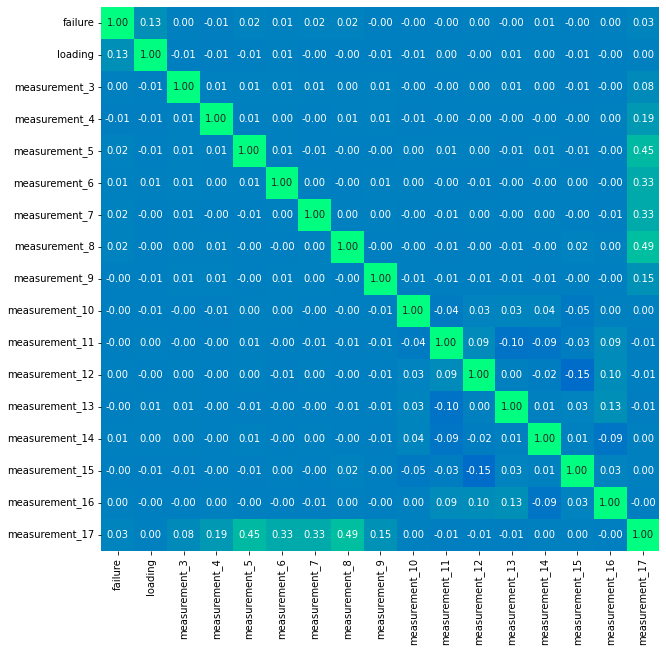

In [86]:
plt.subplots(figsize=(10,10))
sns.heatmap(train[['failure'] + float_cols].corr(), annot=True, fmt = '0.2f', vmin=-1, vmax=1, cmap='winter', cbar=False)

Int features

<AxesSubplot:>

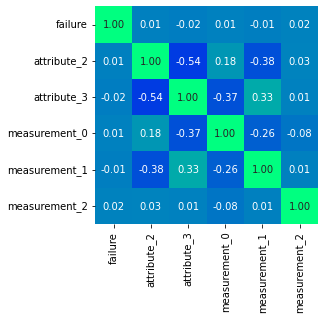

In [88]:
plt.subplots(figsize=(4,4))
sns.heatmap(train[['failure'] + int_cols].corr(), annot=True, fmt = '0.2f', vmin=-1, vmax=1, cmap='winter', cbar=False)

String features

In [108]:
print(string_cols)
print(int_cols)

['product_code', 'attribute_0', 'attribute_1']
['attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2']


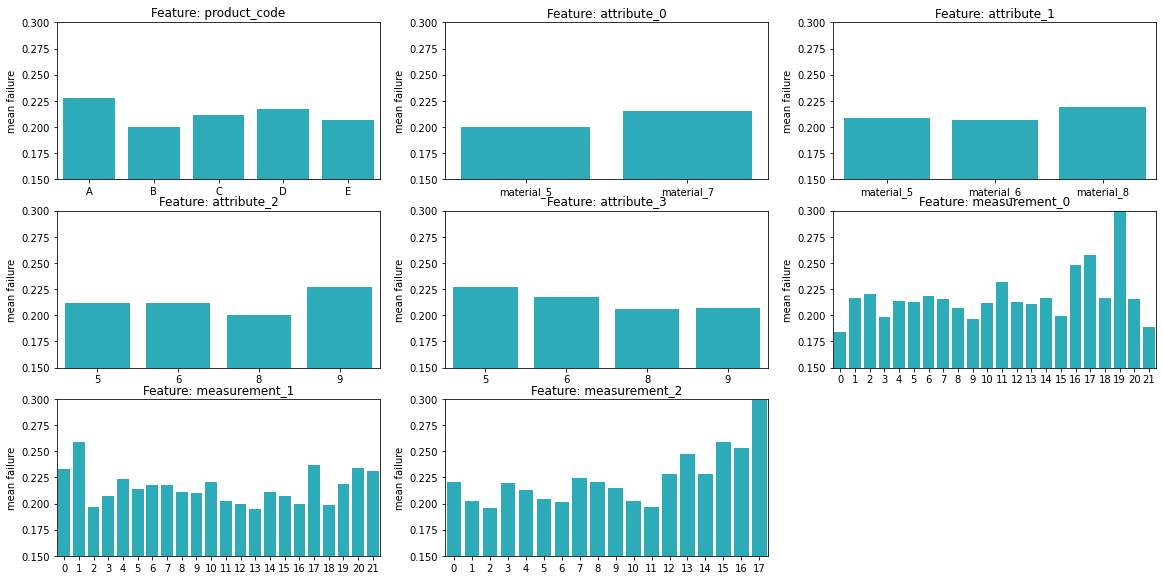

In [110]:
f,ax = plt.subplots(figsize=(16,8))
plt.tight_layout()
for i, column in enumerate(string_cols + int_cols):
    temp_df = train.groupby([column])["failure"].mean()
    temp_df_2 = train[column].value_counts()
    temp_df = temp_df[temp_df_2 > 50]
    plt.subplot(3,3,i+1)
    ax = sns.barplot(x=temp_df.index, y=temp_df.values, color="tab:cyan")
    ax.set_ylim([0.15,0.3])
    plt.ylabel("mean failure")
    plt.xlabel(None)
    plt.title("Feature: " + column)
plt.show()